In [1]:
%load_ext autoreload
%autoreload 2
from targets.conditional_density_estimation_target import *

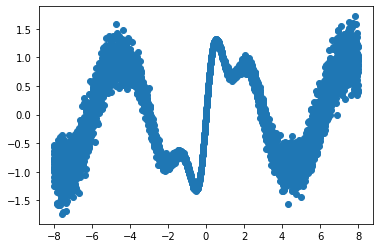

In [2]:
target = Wave()
theta = target.sample_prior(5000)
x = target.simulate(theta)
fig = plt.scatter(theta.squeeze(-1).numpy(), x.squeeze(-1).numpy())
plt.show()

In [3]:
from models_dif import ConditionalDIFDensityEstimator
architecture = ConditionalDIFDensityEstimator
K = 1
hidden_dimensions = [32,32]
from prettytable import PrettyTable

def count_parameters():
    model = architecture(x, theta,K,hidden_dimensions)
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
number_param = count_parameters()
print(number_param)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| w.f.0.weight |     64     |
|  w.f.0.bias  |     32     |
| w.f.2.weight |    1024    |
|  w.f.2.bias  |     32     |
| w.f.4.weight |     32     |
|  w.f.4.bias  |     1      |
| T.f.0.weight |     32     |
|  T.f.0.bias  |     32     |
| T.f.2.weight |    1024    |
|  T.f.2.bias  |     32     |
| T.f.4.weight |     64     |
|  T.f.4.bias  |     2      |
+--------------+------------+
Total Trainable Params: 2371
2371


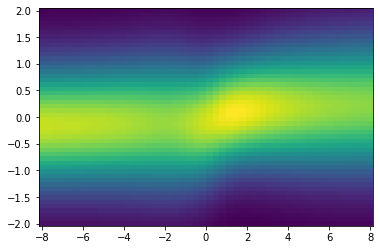

KeyboardInterrupt: 

In [5]:
import copy
from IPython.display import clear_output
theta_linspace = torch.linspace(-8.,8.,50)
x_linspace = torch.linspace(-2.,2.,50)
grid_theta,grid_x = torch.meshgrid(theta_linspace, x_linspace, indexing = 'ij')

current_model = ConditionalDIFDensityEstimator(x, theta, K, hidden_dimensions)
sigma_phi = 1
parameters_as_vector = torch.nn.utils.parameters_to_vector(current_model.parameters())
log_prior = torch.distributions.MultivariateNormal(torch.zeros(parameters_as_vector.shape[0]), (sigma_phi**2)*torch.eye(parameters_as_vector.shape[0])).log_prob(parameters_as_vector)
log_prob = -current_model.loss(x, theta)*x.shape[0] + log_prior
log_prob.backward()

eta = 0.05/parameters_as_vector.shape[0]
for i in range(20000):
    tau = eta/(i+1)
    if i%1 ==0:
        clear_output(wait = True)
        plt.figure()
        density = current_model.log_density(grid_x.unsqueeze(-1), grid_theta.unsqueeze(-1))
        plt.pcolormesh(grid_theta, grid_x,torch.exp(density).detach().numpy())
        plt.show()

    #copy model
    copy_model = copy.deepcopy(current_model)
    
    #Update parameters with langevein dynamics with current gradient values
    for param, copy_param in zip(current_model.parameters(), copy_model.parameters()):
        with torch.no_grad():
            copy_param.data= param.data+tau*param.grad + torch.randn_like(param.data)*((2*tau)**(1/2)) 
            
    #compute new_log_prob
    copy_parameters_as_vector = torch.nn.utils.parameters_to_vector(copy_model.parameters())
    copy_log_prior = torch.distributions.MultivariateNormal(torch.zeros(copy_parameters_as_vector.shape[0]), (sigma_phi**2)*torch.eye(copy_parameters_as_vector.shape[0])).log_prob(copy_parameters_as_vector)
    copy_log_prob = -copy_model.loss(x, theta)*x.shape[0] + copy_log_prior
    
    #compute new gradients
    copy_model.zero_grad()
    copy_log_prob.backward()
    
    #compute acceptance probability
    with torch.no_grad():
        log_ratio = 0
        for param, new_param in zip(current_model.parameters(),copy_model.parameters()):
            log_ratio -= torch.sum(torch.square(param - new_param - tau*new_param.grad))/(4*tau)
            log_ratio += torch.sum(torch.square(new_param - param - tau*param.grad))/(4*tau)
        acceptance_log_prob = copy_log_prob - log_prob + log_ratio
        
    #print(torch.exp(acceptance_log_prob))
    if torch.rand(1)<torch.exp(acceptance_log_prob.detach()):
        print('accepted')
        current_model = copy_model
        log_prob = copy_log_prob

    